/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


7.225555555555555
         local  rack_local  launched  ...  bin  launced  node_local
8     0.000000    0.000000       NaN  ...  5.0      0.0         0.0
0     1.769231    0.230769       2.0  ...  NaN      NaN         NaN
1     3.750000    0.250000       4.0  ...  NaN      NaN         NaN
2    18.800000    1.200000      20.0  ...  NaN      NaN         NaN
3    32.333333    1.666667      50.0  ...  NaN      NaN         NaN
4    94.500000    4.500000     100.0  ...  NaN      NaN         NaN
5   187.000000    5.500000     200.0  ...  NaN      NaN         NaN
6   387.000000    4.000000     400.0  ...  NaN      NaN         NaN
7  2749.000000   46.000000    2802.5  ...  NaN      NaN         NaN

[9 rows x 9 columns]


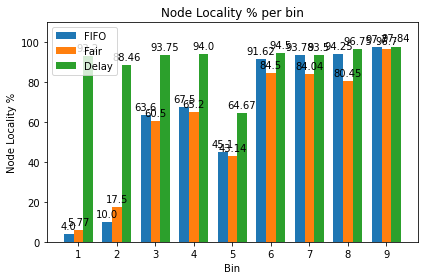

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fifoSchedularResults = pre_process_dataframe('jobs_fifo.txt')
fairSchedularResults = pre_process_dataframe('jobs_fair.txt')
delaySchedularResults = pre_process_dataframe('jobs_delay.txt')

total_maps = fairSchedularResults['launched'].sum()
print(total_maps/ 1800)

results_fifo = fifoSchedularResults.groupby(by='bin').mean()
results_fair = fairSchedularResults.groupby(by='bin').mean()
results_delay = delaySchedularResults.groupby(by='bin').mean()

print(results_delay)

labels = np.arange(9) + 1
labels = labels.astype(str)

node_locality_fifo = results_fifo['node_locality'].to_numpy()
node_locality_fair = results_fair['node_locality'].to_numpy()
node_locality_delay = results_delay['node_locality'].to_numpy()

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, node_locality_fifo, width, label='FIFO')
rects2 = ax.bar(x, node_locality_fair, width, label='Fair')
rects3 = ax.bar(x + width, node_locality_delay, width, label='Delay')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Node Locality %')
ax.set_title('Node Locality % per bin')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ybound(0, 110)
ax.set_xlabel('Bin')
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig("locality.png")
plt.show()

In [ ]:
# Generate a bunch of usefull statistics for the dataframe and clean input

def get_bin_group(n_maps):
  if n_maps > 1 and n_maps <=2:
    return 1
  if n_maps > 2 and n_maps <=10:
    return 2
  if n_maps > 10 and n_maps <=25:
    return 3
  if n_maps > 25 and n_maps <= 50:
    return 4
  if n_maps >= 50 and n_maps <=99:
    return 5
  if n_maps > 99 and n_maps < 200:
    return 6
  if n_maps >= 200 and n_maps < 300:
    return 7
  if n_maps >= 300 and n_maps < 750:
    return 8
  if n_maps >= 750:
    return 9
  
  return 0

def convert_time(time):
  # no minutes
  if time.find('m') == -1:
    return str(time)[2:-4]
  
  # Minutes in tag, find the right positions etc
  min_loc = time.find('m')
  minutes = time[2:min_loc]
  seconds = time[min_loc+5:-4]
  # Convert minutes to seconds
  return int(minutes) * 60 + int(seconds)

def pre_process_dataframe(filename):
  results = pd.read_csv(filename, delimiter='|')
  results.columns = ['job','local', 'rack_local', 'launched', 'time']
  results = results.iloc[:,1:]
  results = results.replace({',': ''}, regex=True) # Remove all the weird commas

  # Convert all to floats
  results['local'] = results['local'].astype(float)
  results['rack_local'] = results['rack_local'].astype(float)
  results['launched'] = results['launched'].astype(float)

  results.loc[:, 'time'] = results.loc[:, 'time'].apply(lambda x: float(convert_time(x)))
  
  results.loc[:, 'bin'] = results.loc[:, 'launched'].apply(lambda x: float(get_bin_group(x)))

  results = results.query("bin != 0")

  results.loc[:, 'node_locality'] = results.loc[:, 'local'] / results.loc[:,'launched'] * 100
  results.loc[:, 'rack_locality'] = results.loc[:,'rack_local'] / results.loc[:,'launched'] * 100
  
  return results

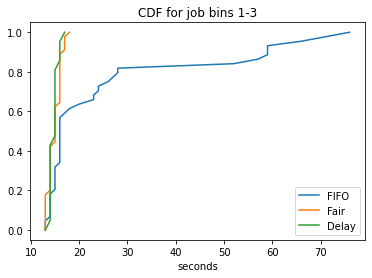

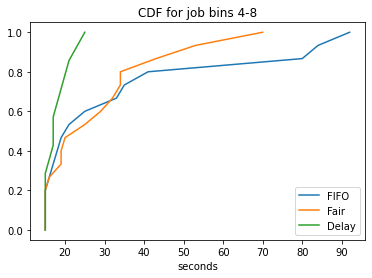

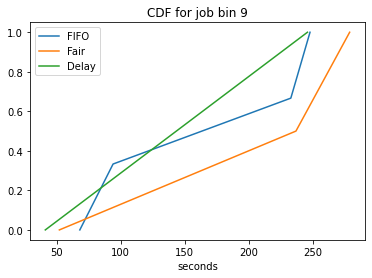

In [13]:
## CDF code
def generate_cdf(dataset):
  data_sorted = np.sort(dataset)
  p = 1. * np.arange(len(dataset)) / (len(dataset) - 1)
  return data_sorted, p 

# Bin 1-3
bin_1_3_fifo = fifoSchedularResults.query("bin == 1 or bin == 2 or bin == 3").loc[:, 'time'].to_numpy()
bin_1_3_fair = fairSchedularResults.query("bin == 1 or bin == 2 or bin == 3").loc[:, 'time'].to_numpy()
bin_1_3_delay = delaySchedularResults.query("bin == 1 or bin == 2 or bin == 3").loc[:, 'time'].to_numpy()

bin_1_3_fifo, p_1_3_fifo = generate_cdf(bin_1_3_fifo)
bin_1_3_fair, p_1_3_fair = generate_cdf(bin_1_3_fair)
bin_1_3_delay, p_1_3_delay = generate_cdf(bin_1_3_delay)

plt.plot(bin_1_3_fifo, p_1_3_fifo, label='FIFO')
plt.plot(bin_1_3_fair, p_1_3_fair, label='Fair')
plt.plot(bin_1_3_delay, p_1_3_delay, label='Delay')

plt.title('CDF for job bins 1-3')
plt.xlabel('seconds')
plt.legend()
plt.savefig("cdf_1.png")
plt.show()
plt.close()

# Bin 4-8
bin_4_8_fifo = fifoSchedularResults.query("bin == 4 or bin == 5 or bin == 6 or bin == 7 or bin == 8").loc[:, 'time'].to_numpy()
bin_4_8_fair = fairSchedularResults.query("bin == 4 or bin == 5 or bin == 6 or bin == 7 or bin == 8").loc[:, 'time'].to_numpy()
bin_4_8_delay = delaySchedularResults.query("bin == 4 or bin == 5 or bin == 6 or bin == 7 or bin == 8").loc[:, 'time'].to_numpy()

bin_4_8_fifo, p_4_8_fifo = generate_cdf(bin_4_8_fifo)
bin_4_8_fair, p_4_8_fair = generate_cdf(bin_4_8_fair)
bin_4_8_delay, p_4_8_delay = generate_cdf(bin_4_8_delay)

plt.plot(bin_4_8_fifo, p_4_8_fifo, label='FIFO')
plt.plot(bin_4_8_fair, p_4_8_fair, label='Fair')
plt.plot(bin_4_8_delay, p_4_8_delay, label='Delay')

plt.title('CDF for job bins 4-8')
plt.xlabel('seconds')
plt.legend()
plt.savefig("cdf_2.png")
plt.show()
plt.close()

# Bin 9
bin_9_fifo = fifoSchedularResults.query("bin == 9").loc[:, 'time'].to_numpy()
bin_9_fair = fairSchedularResults.query("bin == 9").loc[:, 'time'].to_numpy()
bin_9_delay = delaySchedularResults.query("bin == 9").loc[:, 'time'].to_numpy()

bin_9_fifo, p_9_fifo = generate_cdf(bin_9_fifo)
bin_9_fair, p_9_fair = generate_cdf(bin_9_fair)
bin_9_delay, p_9_delay = generate_cdf(bin_9_delay)

plt.plot(bin_9_fifo, p_9_fifo, label='FIFO')
plt.plot(bin_9_fair, p_9_fair, label='Fair')
plt.plot(bin_9_delay, p_9_delay, label='Delay')

plt.title('CDF for job bin 9')
plt.xlabel('seconds')
plt.legend()
plt.savefig("cdf_3.png")
plt.show()
plt.close()

 